In [ ]:
import torch
import xarray as xr
import numpy as np
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append('..')

from chaosbench import dataset, config, utils
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
# Initialize observations dataset by specifying the training/validation years
train_years = np.arange(1979, 2016)
val_years = test_years = np.arange(2016, 2023)

# Also land + ocean variables to be included (acronyms are detailed in the paper)
#land_vars = ['skt', 'src', 'stl1', 'stl2', 'stl3', 'swvl1', 'swvl2', 'swvl3']
#ocean_vars = ['somxl010', 'somxl030', 'sosaline', 'sossheig', 'sosstsst'] # 
land_vars = ['t2m', 'swvl1', 'swvl2', 'swvl3', 'lai_hv', 'lai_lv']
ocean_vars = ['sosstsst']

train_dataset = dataset.S2SObsDataset(years=train_years, land_vars=land_vars, ocean_vars=ocean_vars)
val_dataset = dataset.S2SObsDataset(years=val_years, land_vars=land_vars, ocean_vars=ocean_vars)

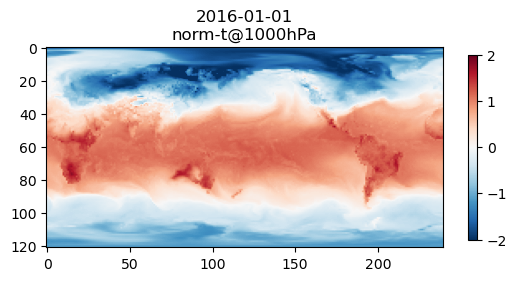

In [4]:
# Visualize input features (eg. normalized surface temperature)
time_idx = 0
param = 't'
level = 1000

timestamp, val_x, val_y = val_dataset[time_idx]

plt.imshow(
    val_x[
        utils.get_param_level_idx(param, level)
    ],
    cmap='RdBu_r', vmin=-2, vmax=2
)

plt.colorbar(shrink=0.5)
plt.title(f'{utils.convert_time(timestamp)}\nnorm-{param}@{level}hPa')
plt.show();

Also, the observational LRA5 terrestrial dataset

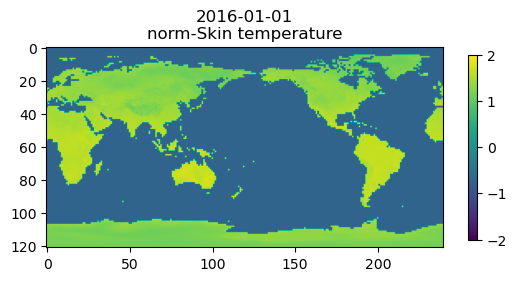

In [4]:
# Visualize boundary features (e.g., skin temperature)
time_idx = 0

timestamp, val_x, val_y = val_dataset[time_idx]

plt.imshow(
    val_x[int(len(config.PARAMS) * len(config.PRESSURE_LEVELS))],
    cmap='viridis', vmin=-2, vmax=2
)

plt.colorbar(shrink=0.5)
plt.title(f'{utils.convert_time(timestamp)}\nnorm-Skin temperature')
plt.show();

Finally, visualizing the observational ORAS5 sea-ice dataset

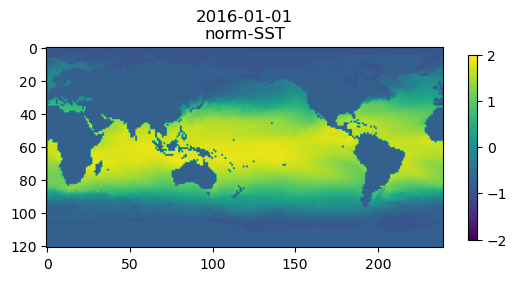

In [5]:
# Visualize boundary features (e.g., sea surface temperature)
time_idx = 0

timestamp, val_x, val_y = val_dataset[time_idx]

plt.imshow(
    val_x[-1],
    cmap='viridis', vmin=-2, vmax=2
)

plt.colorbar(shrink=0.5)
plt.title(f'{utils.convert_time(timestamp)}\nnorm-SST')
plt.show();

In [8]:
# One snapshot of observation has the following shape: (param_era + param_lra + param_oras, lat, lon)
val_x.shape

torch.Size([73, 121, 240])

### Optional: only if you have downloaded the center's simulation data

Now we visualize and check the shape of our benchmark data..

`is_ensemble=False`: control forecasts; `is_ensemble=True` : perturbed forecasts

In [9]:
test_years = test_years = np.arange(2022, 2024)
test_dataset = dataset.S2SEvalDataset(s2s_name='ncep', years=test_years, is_ensemble=True)
timestamp, test_x, test_y = test_dataset[time_idx]
test_y.shape

torch.Size([44, 15, 60, 121, 240])

Notice that we have an additional dimension in the first-axis (ie. size = 44). This indicates the forecasting step, where the first one indicates the present prediction, incremented every 24-hour (1-day) for 44 days ahead. If you set `is_ensemble=True`, the second axis indicates the ensemble number.

We can visualize this more clearly in the following figure...

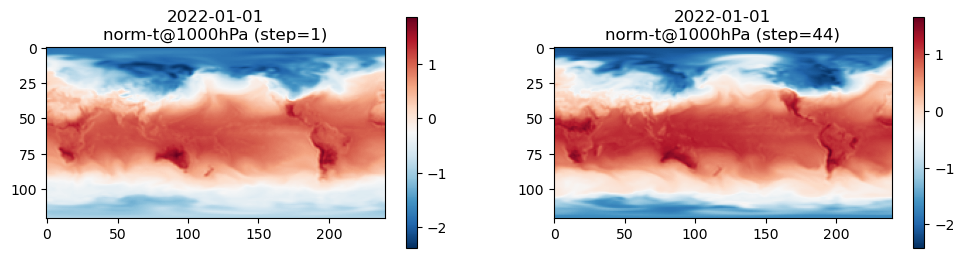

In [10]:
# Visualize s2s benchmark dataset
step_start = 0
step_end = test_y.shape[0] - 1

## Plot
f, ax = plt.subplots(1,2,figsize=(12,6))

im0 = ax[0].imshow(test_y[step_start, 0][utils.get_param_level_idx(param, level)],cmap='RdBu_r')
ax[0].set_title(f'{utils.convert_time(timestamp)}\nnorm-{param}@{level}hPa (step={step_start+1})')
cbar0 = f.colorbar(im0, ax=ax[0], shrink=0.5)

im1 = ax[1].imshow(test_y[step_end, 0][utils.get_param_level_idx(param, level)],cmap='RdBu_r')
ax[1].set_title(f'{utils.convert_time(timestamp)}\nnorm-{param}@{level}hPa (step={step_end+1})')
cbar1 = f.colorbar(im1, ax=ax[1], shrink=0.5)

plt.show();